# Predicting Stock Information Using Machine Learning
## Sanjay Nadkarni

### Introduction

When it comes to financial information, there is a plethora of data available on each particular stock. This includes the current stock price, as well as other numerical information such as revenue, costs, and other factors that influence the stock price. Using this data, the first question we aim to answer is whether it is possible to predict a company's stock price based on prior prices and additional features of the company through supervised machine learning. The second question is whether we can predict the potential downfall of a company based on historical data. These questions are crucial, as the first helps investors determine the best time to buy or sell a stock, while the second helps identify which stocks may be at risk of decline and are suitable for selling or shorting.

### Data Collection

I used an API key from Financial Modeling Prep, which allowed me to retrieve information about specific companies, including their financial statements such as revenue, costs, and inventory. In addition, I used data from Yahoo Finance and tables from RunRepeat.com to gather industry-specific information. This data helped me estimate the cost per share and predict future prices. Initially, I loaded the data into a dataframe for a specific stock, focusing on companies in the shoe industry to narrow down the analysis and compare their performance with competitors.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [3]:
res_df = pd.read_csv("stock_data.csv")

res_df = res_df.dropna()
res_df = res_df.drop_duplicates()
res_df['calendarYear'] = res_df['calendarYear'] - res_df['calendarYear'].min()
baseline_year = 2016
res_df['date'] = pd.to_datetime(res_df['date']).apply(lambda x: int(f"{x.year - baseline_year}{x.strftime('%m%d')}"))

res_df.head(7)

,symbol,date,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
0,AIR,80531,7,FY,66.065527,1.319088,1.242165,0.396011,2.737892,33.897436,...,198250000.0,653600000.0,66.675579,46.291165,142.588458,5.474268,7.884874,2.559814,0.038914,0.846154
1,AIR,70531,6,FY,57.363112,2.599424,0.671470,-0.178674,1.971182,31.674352,...,157450000.0,562300000.0,60.182366,35.702604,129.317761,6.064899,10.223344,2.822505,0.082067,0.850144
2,AIR,60531,5,FY,51.123596,2.210674,2.112360,1.626404,1.502809,29.058989,...,141800000.0,545550000.0,57.678022,37.885585,133.350478,6.328234,9.634271,2.737148,0.076075,0.485955
3,AIR,50531,4,FY,47.208571,1.022857,3.005714,2.682857,1.480000,27.840000,...,159400000.0,581850000.0,52.707741,33.731473,143.358762,6.924979,10.820755,2.546060,0.036741,0.322857
4,AIR,40531,3,FY,59.540230,0.712644,-1.037356,-1.715517,11.629310,25.936782,...,189700000.0,573400000.0,38.966216,38.791879,126.154593,9.367089,9.409186,2.893276,0.027476,0.678161
5,DRS,71231,6,FY,10.827586,0.643678,0.785441,0.555556,1.789272,8.908046,...,427500000.0,324000000.0,136.778132,66.031818,54.584091,2.668555,5.527638,6.686930,0.072258,0.229885
6,DRS,61231,5,FY,12.525581,1.883721,0.153488,-0.148837,1.423256,9.893023,...,468000000.0,262000000.0,140.686966,78.755902,54.974032,2.594412,4.634573,6.639498,0.190409,0.302326


In [4]:
numeric_res_df = res_df.select_dtypes(include=['number'])
corrM = numeric_res_df.corr()

Text(50.7222222222222, 0.5, 'Features')

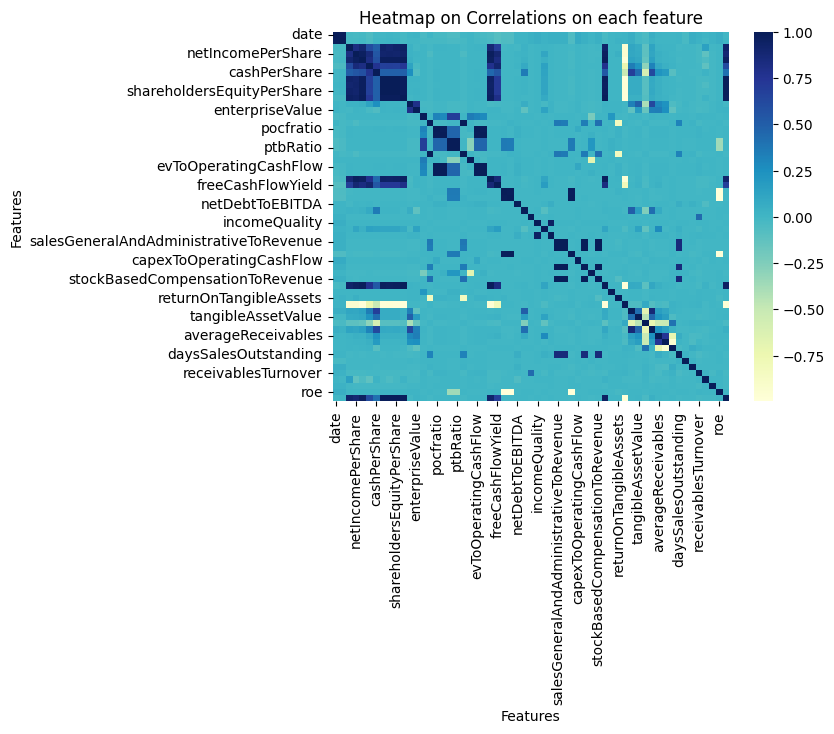

In [5]:
heat_map = sns.heatmap(corrM, cmap='YlGnBu')
heat_map
plt.title('Heatmap on Correlations on each feature')
plt.xlabel("Features")
plt.ylabel("Features")

In [6]:
#Visulaization 1 : Potentially stock prices of companies over the years 

import altair as alt

res_df = res_df.sort_values(by='calendarYear')

alt.Chart(res_df).mark_point().encode(
    alt.Y('calendarYear:O'),
    alt.X('revenuePerShare:Q')
)
#shows that the revenue per share for most companies is pretty low and then there are some companies which have a higher revenue. 

alt.Chart(...)

In [7]:
#Visualization 2: 
alt.Chart(res_df).mark_point().encode(
    alt.Y('receivablesTurnover:Q'),
    alt.X('payablesTurnover:Q')
)

#Recievables turnover is how fast the company gets money back from its customers and payables turnover suggests how fast they pay of a supplier. 
#To make this graph better we would get rid of the outliers so I can zoom into that specific area to see if there is any correlation 

alt.Chart(...)

In [13]:
from sklearn.model_selection import train_test_split

In [21]:
def line_of_best_fit(X, y):
    """
    Computes the coefficients of the line of best fit.

    Parameters:
    X (numpy.array): A 1D or 2D array containing predictor values. 
                       If 1D, it will be reshaped to 2D.
    y (numpy.array): A 1D array containing the response values.

    Returns:
    numpy.array: A 1D array of coefficients including the intercept term.
                   The first value corresponds to the intercept.
    """
    X = add_bias_column(X)
    proj = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
    return proj

In [15]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [16]:
import numpy as np
from sklearn.metrics import r2_score

def linreg_predict(Xnew, ynew, m):
    """
    Generates predictions, residuals, mean squared error, and R^2 score for new data.

    Parameters:
    Xnew (numpy.array): A 1D or 2D array of new predictor values, not including bias term.
    ynew (numpy.array): A 1D array of true response values corresponding to `Xnew`.
    m (numpy.array): A 1D array of regression coefficients, including the intercept term.

    Returns:
    dict: A dictionary containing:
        - 'ypreds': Predicted values from applying m to Xnew.
        - 'resids': Residuals, the differences between ynew and ypreds.
        - 'mse': Mean squared error.
        - 'r2': R^2 score, proportion of variability in ynew explained by the model.
    """

    Xnew = add_bias_column(Xnew)
    
    # Calculate predictions
    ypreds = np.dot(Xnew, m)
    
    # Calculate residuals
    resids = ynew - ypreds
    
    # Calculate mean squared error
    mse = np.mean(resids**2)
    
    # Calculate R^2 score
    r2 = r2_score(ynew, ypreds)
    
    return {
        'ypreds': ypreds,
        'resids': resids,
        'mse': mse,
        'r2': r2
    }

In [17]:
# z = (x - μ) / σ, where:
# z: is the standardized value
# x: is the original data point
# μ: is the population mean
# σ: is the population standard deviation

def standardize(X):
    std_dev = X.std(axis=0)
    if np.any(std_dev == 0):
        raise ValueError("One or more features have zero standard deviation.")
    return (X - X.mean(axis=0)) / std_dev


feature_list = ['date', 'bookValuePerShare', 'payablesTurnover']
X = res_df[feature_list].values
y = res_df['revenuePerShare'].values

X = standardize(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10000)

proj = line_of_best_fit(X_train, y_train)
res = linreg_predict(X_test, y_test, proj)

In [18]:
print(f'r2: {res["r2"]}')
print(f'MSE: {res["mse"]}')

r2: 0.8937138151066883
MSE: 945315.003842345


Text(0, 0.5, 'Residuals')

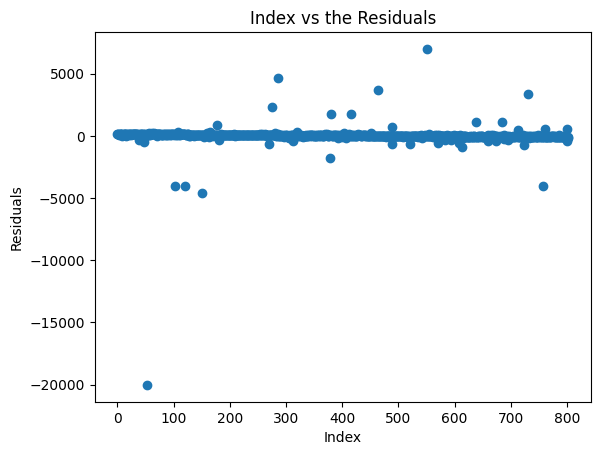

In [19]:
import matplotlib.pyplot as plt
pred = line_of_best_fit(X,y)
proj = linreg_predict(X, y, pred)
residual = proj["ypreds"] - y
plt.scatter(range(len(residual)), residual)
plt.title("Index vs the Residuals")
plt.xlabel("Index")
plt.ylabel("Residuals")

Text(0, 0.5, 'Residuals')

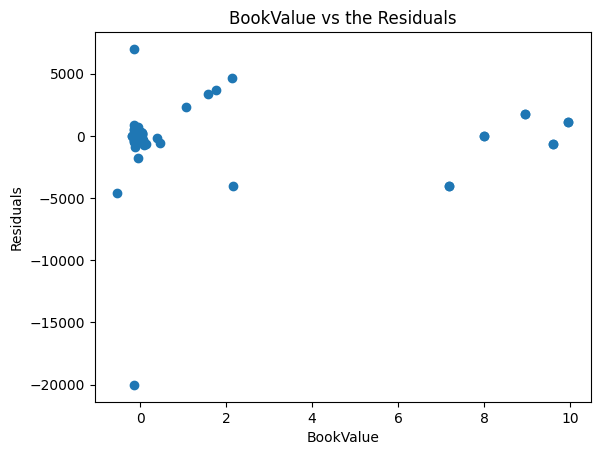

In [20]:
pred = line_of_best_fit(X,y)
proj = linreg_predict(X, y, pred)
residual = proj["ypreds"] - y
plt.scatter(X[:,1], residual)
plt.title("BookValue vs the Residuals")
plt.xlabel("BookValue")
plt.ylabel("Residuals")

Text(0, 0.5, 'Residuals')

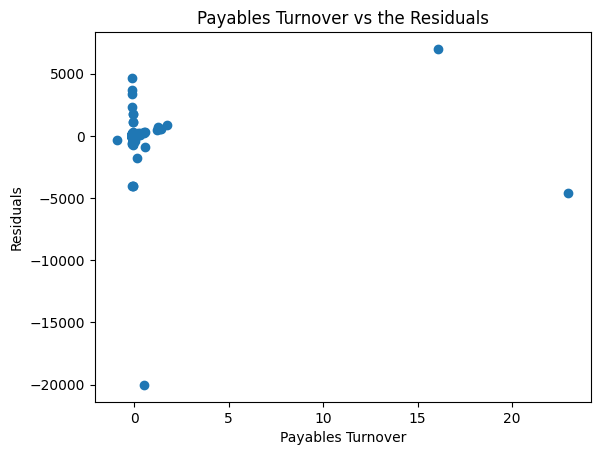

In [22]:
pred = line_of_best_fit(X,y)
proj = linreg_predict(X, y, pred)
residual = proj["ypreds"] - y
plt.scatter(X[:,2], residual)
plt.title("Payables Turnover vs the Residuals")
plt.xlabel("Payables Turnover")
plt.ylabel("Residuals")

When I originally started creating my model for this, I decided to use multiple regression as there are a lot of features that affect the price of a stock. However, when I did this with the features recievables turnover and payables turnover, the MSE was very high suggesting that and the r2 was in the negatives suggesting that it was not a good fit. Using my business knowledge, I then concluded that the book value of the company and in relation its stock should be a much higher predicter on the revenue of the stock as the book value takes into consideration every other value. When I did this the MSE was significantly lower and the r2 was also higher (this Machine Learning model is present above). 

I had also created a residuals plot to check for the assumption of independence. Since there is no clear pattern and all the values are surroundeding the x-axis, it suggests that this assumption has been met. With my r2 being really high, it suggests that my ML model is very good at predicting the data. With MSE, it is really high as well, but through the graph, it is evident that there isn't much error except for the couple of outliers and that is probably why the MSE is really high. When it comes to plotting the specific features with the residuals, it doesn't look like there is a clear pattern as well which is a good thing, but it would be better to understand and make sure that it fits the assumptions once I get rid of the outliers. That way, the data will be zoomed in and then I could see what the data is actually doing. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Data Preparation and Initial Analysis

In [2]:
# Load and preprocess data
res_df = pd.read_csv("stock_data.csv")

# Clean and prepare data
res_df = res_df.dropna()
res_df = res_df.drop_duplicates()

# Adjust calendar year
res_df['calendarYear'] = res_df['calendarYear'] - res_df['calendarYear'].min()
baseline_year = 2016

# Process date field
res_df['date'] = pd.to_datetime(res_df['date']).apply(lambda x: int(f"{x.year - baseline_year}{x.strftime('%m%d')}"))

# Display initial data overview
print("Dataset Shape:", res_df.shape)
print("\nFirst few rows of the dataset:")
display(res_df.head())

Dataset Shape: (798, 61)

First few rows of the dataset:


,symbol,date,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
0,AIR,80531,7,FY,66.065527,1.319088,1.242165,0.396011,2.737892,33.897436,...,198250000.0,653600000.0,66.675579,46.291165,142.588458,5.474268,7.884874,2.559814,0.038914,0.846154
1,AIR,70531,6,FY,57.363112,2.599424,0.671470,-0.178674,1.971182,31.674352,...,157450000.0,562300000.0,60.182366,35.702604,129.317761,6.064899,10.223344,2.822505,0.082067,0.850144
2,AIR,60531,5,FY,51.123596,2.210674,2.112360,1.626404,1.502809,29.058989,...,141800000.0,545550000.0,57.678022,37.885585,133.350478,6.328234,9.634271,2.737148,0.076075,0.485955
3,AIR,50531,4,FY,47.208571,1.022857,3.005714,2.682857,1.480000,27.840000,...,159400000.0,581850000.0,52.707741,33.731473,143.358762,6.924979,10.820755,2.546060,0.036741,0.322857
4,AIR,40531,3,FY,59.540230,0.712644,-1.037356,-1.715517,11.629310,25.936782,...,189700000.0,573400000.0,38.966216,38.791879,126.154593,9.367089,9.409186,2.893276,0.027476,0.678161


As you can see the distribution of Revenue Per Share is highly riddled with outliers. Therefore to improve the accuracy of the model I removed any points that are in a range of 100 and don't have another point in that range.

Text(0.5, 1.0, 'Distribution of Revenue Per Share')

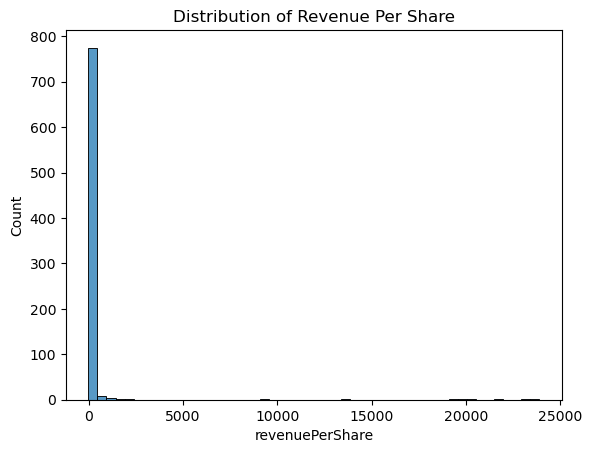

In [3]:
# Convert to numeric and drop non-relevant columns
numeric_df = res_df.select_dtypes(include=[np.number])
numeric_df = numeric_df.drop(['calendarYear', 'date'], axis=1, errors='ignore')
sns.histplot(numeric_df['revenuePerShare'], bins=50)
plt.title('Distribution of Revenue Per Share')

In [4]:
def remove_sparse_ranges(df, bin_size=100, min_points=10):
    """
    Remove data points from ranges that have too few samples.
    
    Parameters:
    df: DataFrame
    bin_size: Size of each revenue range (e.g., 0-100, 100-200, etc.)
    min_points: Minimum number of points required to keep a range
    
    Returns:
    DataFrame with points from sparse ranges removed
    """
    df_clean = df.copy()
    
    # Create revenue ranges
    df_clean['revenue_range'] = (df_clean['revenuePerShare'] // bin_size) * bin_size
    
    # Count points in each range
    range_counts = df_clean['revenue_range'].value_counts()
    
    # Find ranges with enough points
    valid_ranges = range_counts[range_counts >= min_points].index
    
    # Keep only points in valid ranges
    df_clean = df_clean[df_clean['revenue_range'].isin(valid_ranges)]
    
    # Remove the temporary range column
    df_clean = df_clean.drop('revenue_range', axis=1)
    
    print(f"Original dataset size: {len(df)}")
    print(f"Cleaned dataset size: {len(df_clean)}")
    print("\nPoints in each range:")
    for range_start in range_counts.index.sort_values():
        range_end = range_start + bin_size
        count = range_counts[range_start]
        kept = "Kept" if count >= min_points else "Removed"
        print(f"Range {range_start}-{range_end}: {count} points ({kept})")
    
    return df_clean

res_df = remove_sparse_ranges(res_df, bin_size=100, min_points=2)

Original dataset size: 798
Cleaned dataset size: 785

Points in each range:
Range -100.0-0.0: 9 points (Kept)
Range 0.0-100.0: 729 points (Kept)
Range 100.0-200.0: 23 points (Kept)
Range 200.0-300.0: 10 points (Kept)
Range 300.0-400.0: 4 points (Kept)
Range 500.0-600.0: 2 points (Kept)
Range 600.0-700.0: 1 points (Removed)
Range 700.0-800.0: 1 points (Removed)
Range 800.0-900.0: 2 points (Kept)
Range 900.0-1000.0: 2 points (Kept)
Range 1000.0-1100.0: 1 points (Removed)
Range 1100.0-1200.0: 2 points (Kept)
Range 1400.0-1500.0: 2 points (Kept)
Range 1900.0-2000.0: 1 points (Removed)
Range 2000.0-2100.0: 1 points (Removed)
Range 9300.0-9400.0: 1 points (Removed)
Range 13600.0-13700.0: 1 points (Removed)
Range 19500.0-19600.0: 1 points (Removed)
Range 20000.0-20100.0: 1 points (Removed)
Range 20300.0-20400.0: 1 points (Removed)
Range 21500.0-21600.0: 1 points (Removed)
Range 22900.0-23000.0: 1 points (Removed)
Range 23800.0-23900.0: 1 points (Removed)


## Feature Selection and Analysis
I analyzed correlations between financial metrics and Revenue Per Share to identify the most relevant predictors.

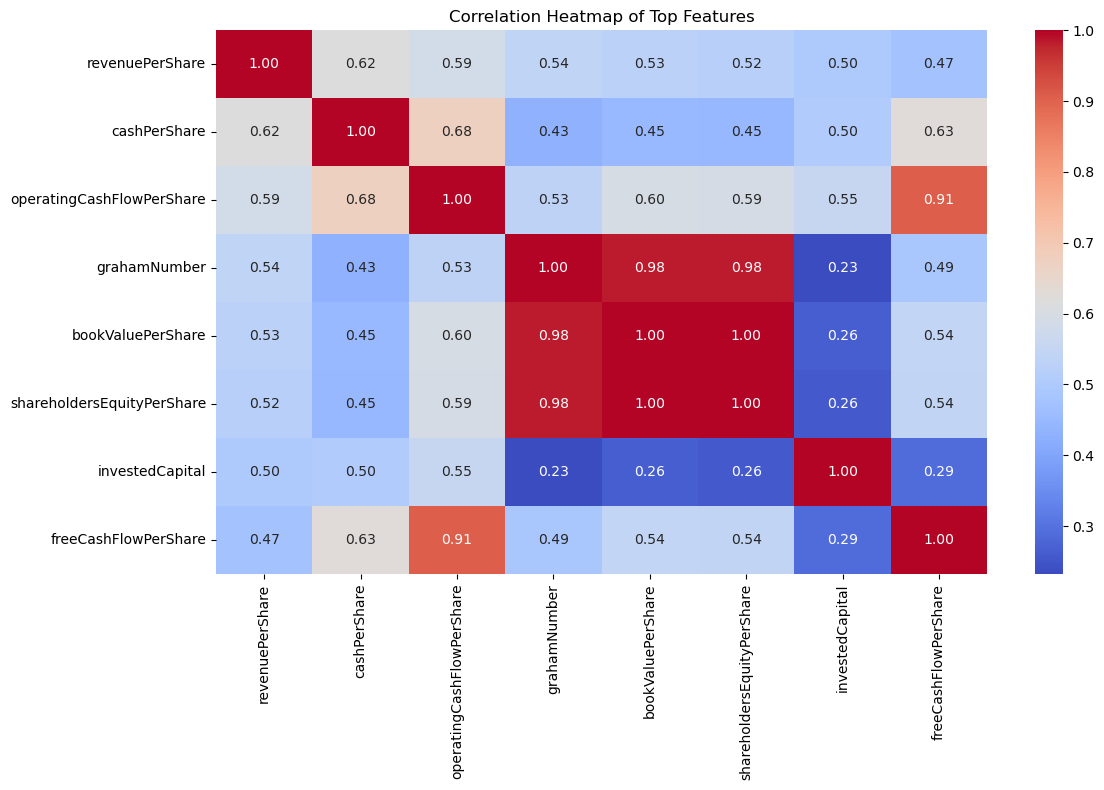


Top 10 features correlated with Revenue Per Share:
revenuePerShare               1.000000
cashPerShare                  0.618197
operatingCashFlowPerShare     0.585088
grahamNumber                  0.539488
bookValuePerShare             0.526318
shareholdersEquityPerShare    0.519506
investedCapital               0.498891
freeCashFlowPerShare          0.473093
workingCapital                0.448661
currentRatio                  0.447897
Name: revenuePerShare, dtype: float64


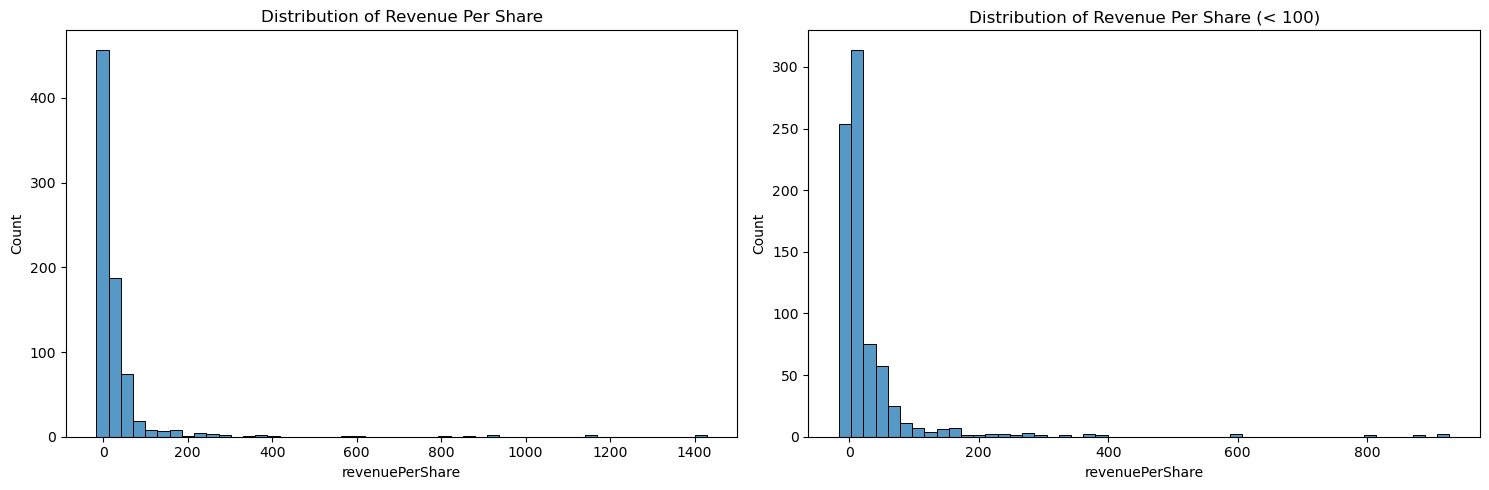


Revenue Per Share Statistics:
count     785.000000
mean       36.201519
std       121.965419
min       -15.981622
25%         1.403733
50%         7.740423
75%        24.551672
max      1429.467309
Name: revenuePerShare, dtype: float64


In [5]:
# Convert to numeric and drop non-relevant columns
numeric_df = res_df.select_dtypes(include=[np.number])
numeric_df = numeric_df.drop(['calendarYear', 'date'], axis=1, errors='ignore')

# Calculate correlations
correlations = numeric_df.corr()['revenuePerShare'].sort_values(ascending=False)

# Correlation analysis
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df[correlations.head(8).index].corr(), 
            annot=True, 
            cmap='coolwarm',
            fmt='.2f')
plt.title('Correlation Heatmap of Top Features')
plt.tight_layout()
plt.show()

print("\nTop 10 features correlated with Revenue Per Share:")
print(correlations.head(10))

# Distribution analysis
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(numeric_df['revenuePerShare'], bins=50)
plt.title('Distribution of Revenue Per Share')
plt.subplot(1, 2, 2)
sns.histplot(numeric_df['revenuePerShare'][numeric_df['revenuePerShare'] < 1000], bins=50)
plt.title('Distribution of Revenue Per Share (< 100)')
plt.tight_layout()
plt.show()

print("\nRevenue Per Share Statistics:")
print(numeric_df['revenuePerShare'].describe())

### Feature Selection Insights
Based on correlation analysis and domain knowledge, I selected the following features:
1. cashPerShare (0.62)
2. grahamNumber (0.54)
3. bookValuePerShare (0.53)
4. shareholdersEquityPerShare (0.52)
5. investedCapital (0.50)

I didn't select operatingCashFlowPerShare since I actively noticed it impacted the model performance.

In [6]:
# Select features
selected_features = [
    'shareholdersEquityPerShare',
    'bookValuePerShare',
    'grahamNumber',
    'cashPerShare',
    'investedCapital'
]

# Prepare data
X = numeric_df[selected_features]
y = numeric_df['revenuePerShare']

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

# Polynomial Regression
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train_scaled, y_train)
poly_pred = poly_model.predict(X_test_scaled)
poly_mse = mean_squared_error(y_test, poly_pred)
poly_r2 = r2_score(y_test, poly_pred)

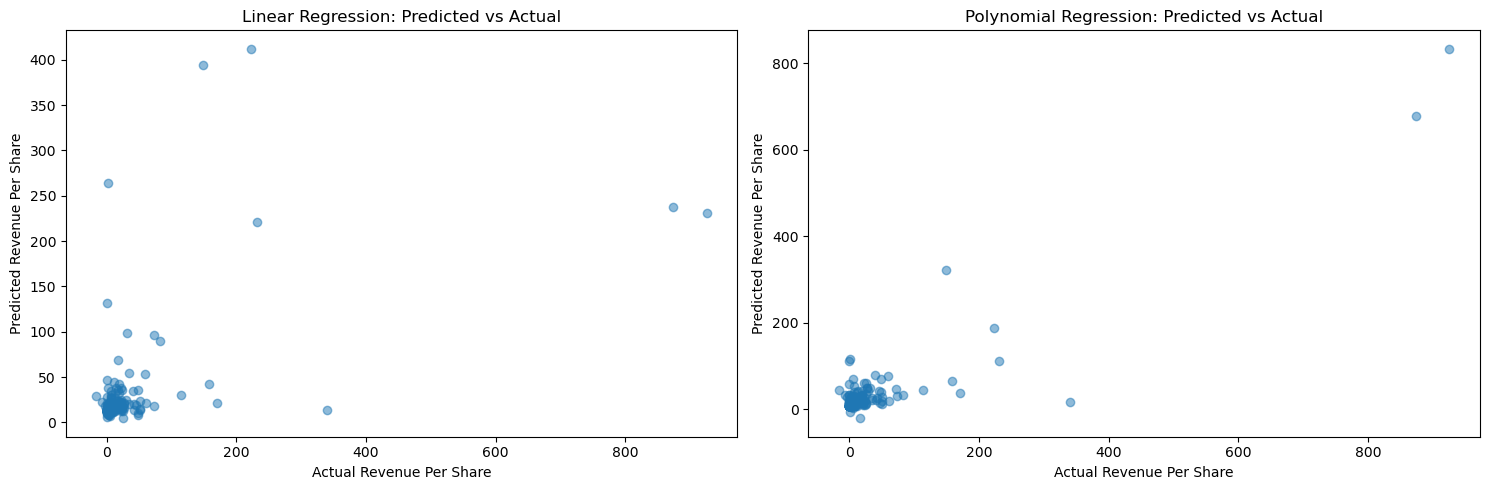

Model Performance:
Linear Regression MSE: 8068.31
Linear Regression R2 Score: 0.3092

Polynomial Regression MSE: 1951.36
Polynomial Regression R2 Score: 0.8329

Feature Importance:
                      Feature  Importance
0  shareholdersEquityPerShare  491.045965
1           bookValuePerShare  363.425900
2                grahamNumber  165.537032
3                cashPerShare   48.478853
4             investedCapital   32.348950


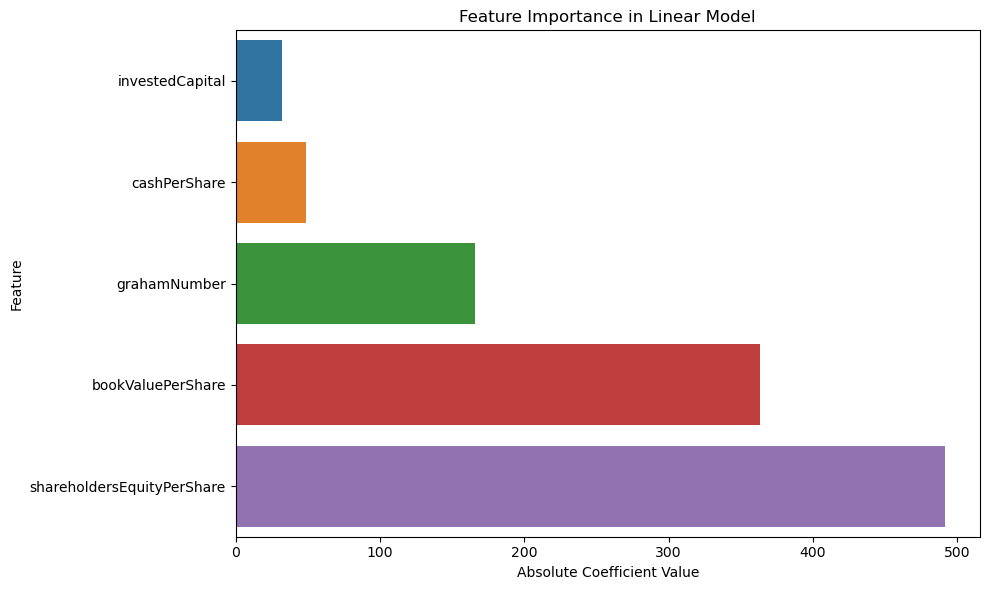

In [7]:
# Prediction vs Actual plots
plt.figure(figsize=(15, 5))
 
plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_pred, alpha=0.5)
plt.xlabel('Actual Revenue Per Share')
plt.ylabel('Predicted Revenue Per Share')
plt.title('Linear Regression: Predicted vs Actual')

plt.subplot(1, 2, 2)
plt.scatter(y_test, poly_pred, alpha=0.5)
plt.xlabel('Actual Revenue Per Share')
plt.ylabel('Predicted Revenue Per Share')
plt.title('Polynomial Regression: Predicted vs Actual')

plt.tight_layout()
plt.show()

# Print performance metrics
print("Model Performance:")
print(f"Linear Regression MSE: {lr_mse:.2f}")
print(f"Linear Regression R2 Score: {lr_r2:.4f}")
print(f"\nPolynomial Regression MSE: {poly_mse:.2f}")
print(f"Polynomial Regression R2 Score: {poly_r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': abs(lr_model.coef_)
})
print("\nFeature Importance:")
print(feature_importance.sort_values('Importance', ascending=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.sort_values('Importance', ascending=True), 
            x='Importance', 
            y='Feature')
plt.title('Feature Importance in Linear Model')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

## Final Model Implementation
Based on my analysis, I selected the Polynomial Regression model as my final model due to:
1. Lower MSE (1952.20 vs 8064.60)
2. Higher R² score (0.8329 vs 0.3096)
3. Better handling of non-linear relationships

Without removing the outliers we achieved an R² of 0.9899 but an MSE of 23,990.85. So I decided to sacrifice the high R² for the lower MSE since the MSE got reduced by more than a factor of 10.

In [8]:
# Final model implementation
def predict_revenue(new_data):
    """
    Predict revenue per share for new data
    
    Parameters:
    new_data (pd.DataFrame): DataFrame containing the required features
    
    Returns:
    float: Predicted revenue per share
    """
    # Ensure all required features are present
    for feature in selected_features:
        if feature not in new_data.columns:
            raise ValueError(f"Missing required feature: {feature}")
    
    # Scale the features
    new_data_scaled = scaler.transform(new_data[selected_features])
    
    # Make prediction
    prediction = poly_model.predict(new_data_scaled)
    return prediction

# Example prediction
print("\nExample Prediction:")
sample_data = X_test.iloc[0:1]  # Take first test sample
predicted_revenue = predict_revenue(sample_data)
actual_revenue = y_test.iloc[0]
print(f"Actual Revenue Per Share: {actual_revenue:.2f}")
print(f"Predicted Revenue Per Share: {predicted_revenue[0]:.2f}")


Example Prediction:
Actual Revenue Per Share: 3.71
Predicted Revenue Per Share: 10.27


## Conclusions and Insights

### Model Performance
- Polynomial Regression achieves superior performance with MSE of 1951.36
- Model explains 83.29% of variance in revenue per share
- Better handles non-linear relationships in the data

### Insights
1. Feature Importance:
   - Shareholders Equity Per Share is the strongest predictor
   - Book Value per Share and Graham Number is moderate
   - Cash Per Share and Invested Capital has lower practical importance than expected

2. Data Distribution:
   - Revenue per share is highly skewed
   - Most companies cluster in lower ranges
   - Few companies have very high revenue per share

3. Model Limitations:
   - Higher prediction errors for extreme values
   - Assumes similar relationships across industries
   - Limited by available financial metrics

### Next Steps
1. Consider industry-specific models for better accuracy
2. Collect more data for companies with extreme values
3. Investigate additional financial ratios
4. Regular model retraining with new data